# Homework 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import cv2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

---
# Часть 1: Свертки

## Реализация

В этом разделе вы реализуете две версии свертки:
- `conv_nested`
- `conv_fast`

Сначала запустите нижеуказанную кодовую ячейку, чтобы загрузить изображение для работы.

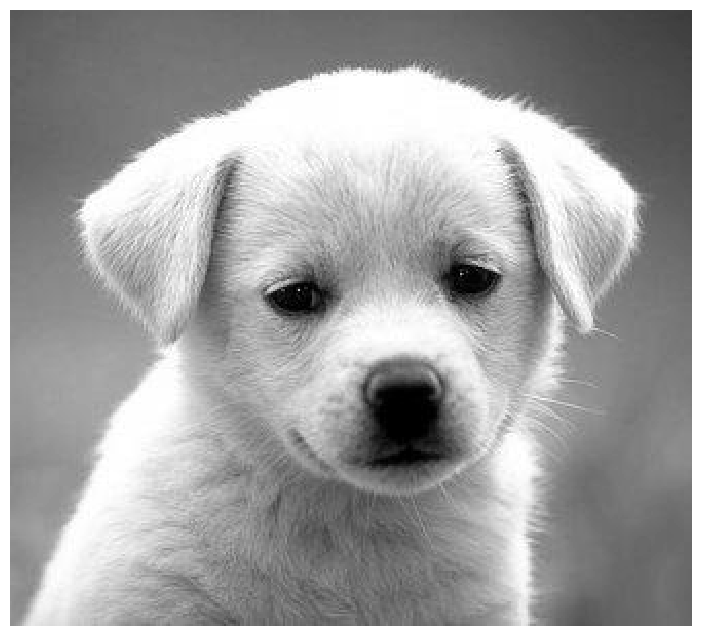

In [4]:
# Open image as grayscale
img = cv2.imread('lab2/img/dog.jpg', 0)

# Show image
plt.imshow(img)
plt.axis('off')
plt.show()

Теперь реализуем функцию **`conv_nested`** в **`filters.py`**. Это наивная реализация convolution, использующая 4 вложенных for-loops. В качестве входа и выхода она берет изображение $f$ и ядро $h$, которое имеет ту же форму, что и входное изображение. Запуск этой реализации должен занять несколько секунд.

*- Подсказка: Возможно, будет проще реализовать $(h*f)$*.

Сначала мы протестируем вашу функцию `conv_nested` на простом входе.

In [5]:
def conv_nested(image, kernel):
	"""A naive implementation of convolution filter.

	This is a naive implementation of convolution using 4 nested for-loops.
	This function computes convolution of an image with a kernel and outputs
	the result that has the same shape as the input image.

	Args:
		image: numpy array of shape (Hi, Wi).
		kernel: numpy array of shape (Hk, Wk).

	Returns:
		out: numpy array of shape (Hi, Wi).
	"""
	image_height, image_width = image.shape
	kernel_height, kernel_width = kernel.shape
	out = np.zeros((image_height, image_width))
	
	pad_height = kernel_height // 2
	pad_width = kernel_width // 2
	kernel = np.flip(kernel)
	image_padded = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

	for i in range(image_height):
		for j in range(image_width):
			pixel_sum = 0.0
			for ii in range(kernel_height):
				for jj in range(kernel_width):
					pixel_sum += kernel[ii, jj] * image_padded[i + ii, j + jj]
			out[i, j] = pixel_sum

	return out

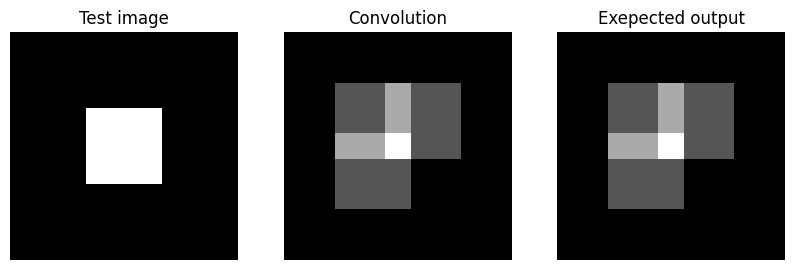

In [6]:
#from filters import conv_nested

# Simple convolution kernel.
g = np.array(
[
	[1,0,1],
	[0,0,0],
	[1,0,0]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, g)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:7, 2:7] = 1
expected_output[5:, 5:] = 0
expected_output[4, 2:5] = 2
expected_output[2:5, 4] = 2
expected_output[4, 4] = 3

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the exepected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Exepected output')
plt.axis('off')
plt.show()

Теперь давайте протестируем вашу функцию `conv_nested` на реальном изображении.

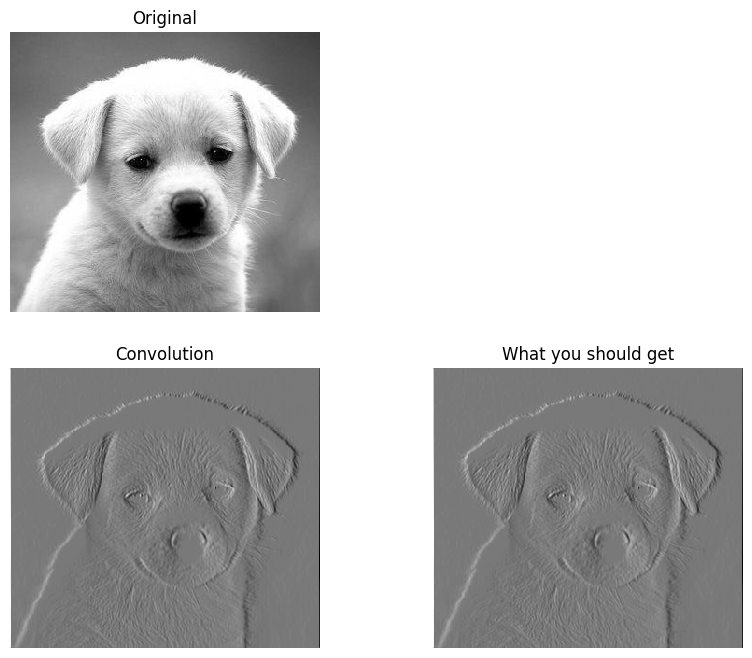

In [7]:
#from filters import conv_nested

# Simple convolution kernel.
# Feel free to change the kernel to see different outputs.
g = np.array(
[
	[1,0,-1],
	[2,0,-2],
	[1,0,-1]
])

out = conv_nested(img, g)
# out = cv2.filter2D(img, -1, kernel)

# Plot original image
plt.subplot(221), plt.imshow(img), plt.title('Original'), plt.axis('off')

# Plot your convolved image
plt.subplot(223), plt.imshow(out), plt.title('Convolution'), plt.axis('off')

# Plot what you should get
solution_img = cv2.imread('lab2/img/convoluted_dog.jpg', 0)
plt.subplot(224), plt.imshow(solution_img), plt.title('What you should get'), plt.axis('off')

plt.show()

In [8]:
out, solution_img

(array([[ 265.,   -3.,   -1., ...,    0.,   -3., -183.],
        [ 355.,   -4.,   -2., ...,    0.,   -3., -244.],
        [ 357.,   -3.,   -1., ...,   -1.,   -2., -244.],
        ...,
        [ 576.,    4.,   18., ...,    0.,   -4., -412.],
        [ 577.,   12.,   32., ...,    0.,   -4., -412.],
        [ 434.,   13.,   29., ...,    0.,   -3., -309.]]),
 array([[179, 121, 121, ..., 121, 121,  81],
        [199, 120, 121, ..., 121, 121,  68],
        [200, 121, 121, ..., 121, 121,  68],
        ...,
        [248, 121, 125, ..., 121, 120,  31],
        [248, 124, 128, ..., 121, 120,  31],
        [216, 124, 128, ..., 121, 121,  54]], dtype=uint8))

Реализуем более эффективный вариант свертки с использованием операций с массивами в numpy. Как показано в лекции, свертку можно рассматривать как скользящее окно, которое вычисляет сумму значений пикселей, взвешенных перевернутым ядром. Более быстрая версия: i) будет иметь нулевое изображение, ii) перевернёт ядро по горизонтали и вертикали, и iii) вычислит взвешенную сумму окрестностей в каждом пикселе.

Во-первых, реализовать функцию **`zero_pad`** в **`filters.py`**.

In [9]:
def zero_pad(image, pad_height, pad_width):
	""" Zero-pad an image.

	Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:

		[[0, 0, 0, 0, 0],
		 [0, 0, 1, 0, 0],
		 [0, 0, 0, 0, 0]]		 of shape (3, 5)

	Args:
		image: numpy array of shape (H, W).
		pad_width: width of the zero padding (left and right padding).
		pad_height: height of the zero padding (bottom and top padding).

	Returns:
		out: numpy array of shape (H+2*pad_height, W+2*pad_width).
	"""

	height, width = image.shape
	out = np.zeros((height + 2 * pad_height, width + 2 * pad_width))
	out[pad_height:height + pad_height, pad_width:width + pad_width] = image
	
	return out

(380, 372)


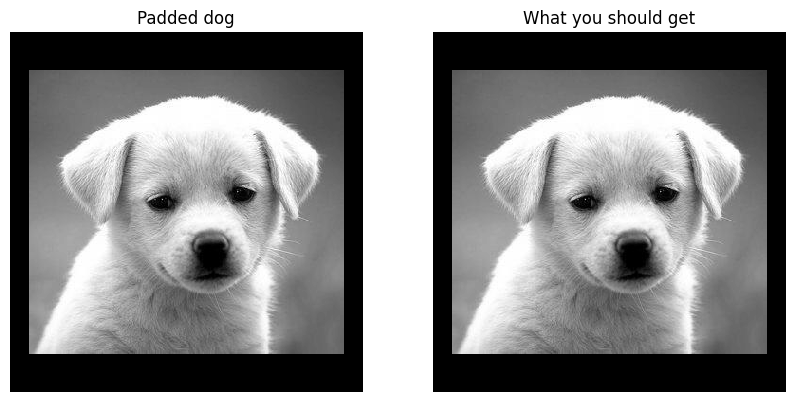

In [10]:
#from lab2.filters import zero_pad

pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)
print(padded_img.shape)


# Plot your padded dog
plt.subplot(121), plt.imshow(padded_img), plt.title('Padded dog'), plt.axis('off')

# Plot what you should get
solution_img = cv2.imread('lab2/img/padded_dog.jpg', 0)
plt.subplot(122), plt.imshow(solution_img), plt.title('What you should get'), plt.axis('off')

plt.show()

Далее, выполните функцию **`conv_fast`** в **`filters.py`** с помощью `zero_pad`. Запустите код ниже, чтобы сравнить результаты по двум реализациям. `conv_fast` должна работать значительно быстрее, чем `conv_nested`.  
В зависимости от вашей реализации и компьютера, `conv_nested` должен занять несколько секунд и `conv_fast` должен работать примерно в 5 раз быстрее.

In [11]:
def conv_fast(image, kernel):
	""" An efficient implementation of convolution filter.

	This function uses element-wise multiplication and np.sum()
	to efficiently compute weighted sum of neighborhood at each
	pixel.

	Hints:
		- Use the zero_pad function you implemented above
		- There should be two nested for-loops
		- You may find np.flip() and np.sum() useful

	Args:
		image: numpy array of shape (Hi, Wi).
		kernel: numpy array of shape (Hk, Wk).

	Returns:
		out: numpy array of shape (Hi, Wi).
	"""
	Hi, Wi = image.shape
	Hk, Wk = kernel.shape
	out = np.zeros((Hi, Wi))
	kernel = np.flip(kernel)
	pad_height = Hk // 2
	pad_width = Wk // 2

	image_padded = zero_pad(image, pad_height, pad_width)
	for i in range(Hi):
		for j in range(Wi):
			region = image_padded[i:i+Hk, j:j+Wk]
			out[i, j] = np.sum(region * kernel)

	return out

conv_nested: took 0.629472 seconds.
conv_fast: took 0.587498 seconds.


(np.float64(-0.5), np.float64(331.5), np.float64(299.5), np.float64(-0.5))

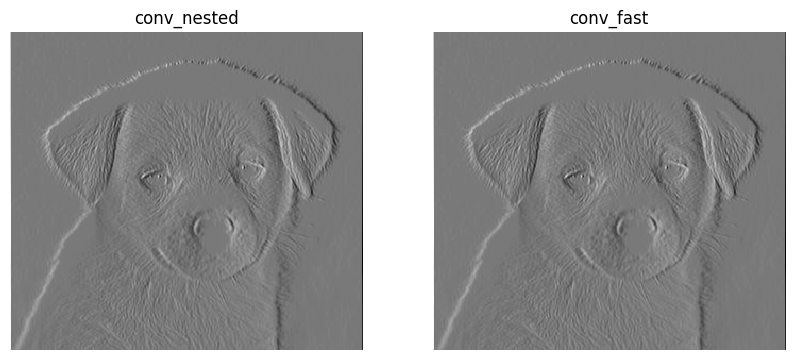

In [12]:
#from lab2.filters import conv_fast

t0 = time()
out_fast = conv_fast(img, g)
t1 = time()
out_nested = conv_nested(img, g)
t2 = time()

# Compare the running time of the two implementations
print("conv_nested: took %f seconds." % (t2 - t1))
print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_nested)
plt.title('conv_nested')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

### Задание со звездочкой

Разработайте более быструю версию свертки и реализуйте **`conv_faster`** в **`filters.py`**. Вы заработаете дополнительный балл в том случае, если `conv_faster` будет работать быстрее (с достаточным запасом), чем `conv_fast` **и** выдаст тот же результат.

In [13]:
def conv_faster(image, kernel):
	"""
	Args:
		image: numpy array of shape (Hi, Wi).
		kernel: numpy array of shape (Hk, Wk).

	Returns:
		out: numpy array of shape (Hi, Wi).
	"""
	Hi, Wi = image.shape
	Hk, Wk = kernel.shape
	out = np.zeros((Hi, Wi))

	out=np.real(np.fft.ifft2(np.fft.fft2(image)*np.fft.fft2(kernel, s=image.shape)))

	return out

conv_fast: took 0.589668 seconds.
conv_faster: took 0.019922 seconds.


(np.float64(-0.5), np.float64(331.5), np.float64(299.5), np.float64(-0.5))

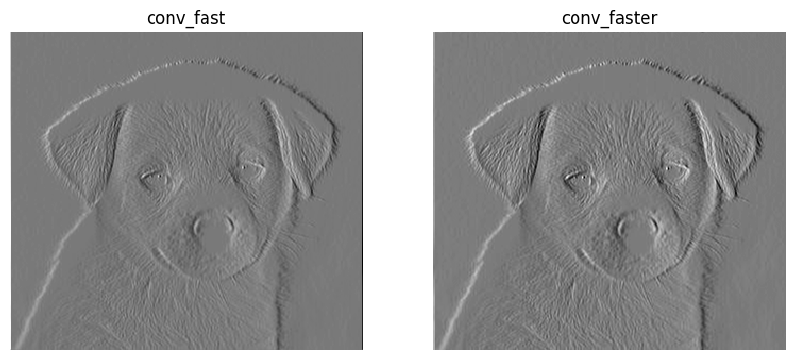

In [14]:
#from filters import conv_faster

t0 = time()
out_fast = conv_fast(img, g)
t1 = time()
out_faster = conv_faster(img, g)
t2 = time()

# Compare the running time of the two implementations
print("conv_fast: took %f seconds." % (t1 - t0))
print("conv_faster: took %f seconds." % (t2 - t1))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_faster)
plt.title('conv_faster')
plt.axis('off')

---
# Часть 2: Кросс-корреляция

Кросс-корреляция двух 2D сигналов $f$ и $g$ определяется следующим образом:
$$(f\star{g})[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot g[m-i,n-j]$$

## Проверка шаблона с помощью кросс-корреляцией 

Предположим, что ты продавщица в продуктовом магазине. Одна из ваших обязанностей - периодически проверять полки и складировать их всякий раз, когда есть распроданные товары. Вы устали от этой кропотливой работы и решили построить систему компьютерного зрения, которая отслеживает предметы на полке.

К счастью, в CS131 вы узнали, что для сопоставления шаблонов можно использовать кросс-корреляцию: шаблон $g$ умножается на регионы с большим изображением $f$, чтобы измерить, насколько каждый регион похож на шаблон.

Шаблон товара (`template.jpg`) и изображение полки (`shelf.jpg`) предоставляются. Мы будем использовать кросс-корреляцию, чтобы найти товар на полке.

Реализуйте функцию **`cross_correlation`** в **`filters.py`** и запустите код ниже.

*- Подсказка: Вы можете использовать функцию `conv_fast`, которую вы реализовали в предыдущем вопросе.

In [15]:
# Load template and image in grayscale
img = cv2.imread('lab2/img/shelf.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_grey = cv2.imread('lab2/img/shelf.jpg', 0)
temp = cv2.imread('lab2/img/template.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
temp_grey = cv2.imread('lab2/img/template.jpg', 0)

In [20]:
def cross_correlation(f, g):
	Hi, Hw = f.shape
	Hk, Wk = g.shape
	pad_height = Hk // 2
	pad_width = Wk // 2
	
	padded_image = np.pad(f, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
	out = np.zeros_like(f)
	for i in range(Hi):
		for j in range(Hw):
			image_region = padded_image[i:i + Hk, j:j + Wk]
			out[i, j] = np.sum(image_region * g)
	
	return out

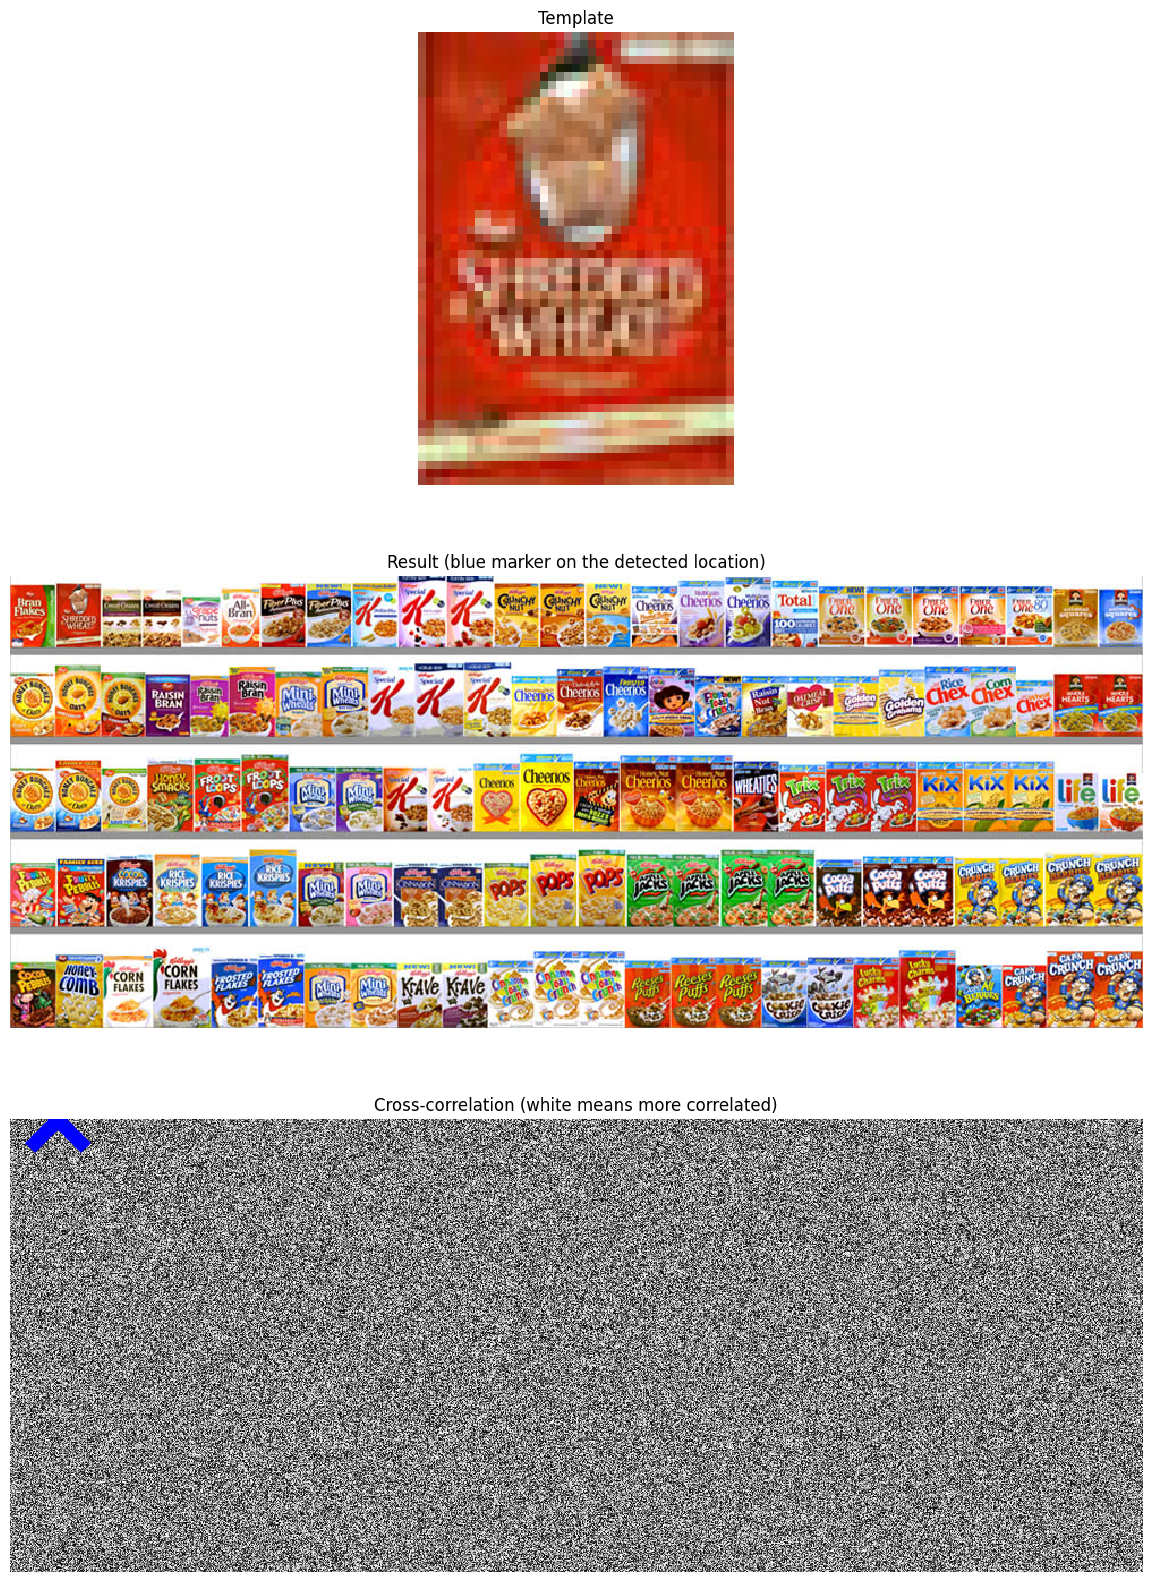

In [22]:
#from filters import cross_correlation
temp_grey=np.flip(temp_grey)
# Perform cross-correlation between the image and the template
out = cross_correlation(img_grey, temp_grey)
# Find the location with maximum similarity
x, y = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(25, 20))

# Display product template
plt.subplot(311), plt.imshow(temp), plt.title('Template'), plt.axis('off') 

# Display image
plt.subplot(312), plt.imshow(img), plt.title('Result (blue marker on the detected location)'), plt.axis('off')

# Display cross-correlation output
plt.subplot(313), plt.imshow(out), plt.title('Cross-correlation (white means more correlated)'), plt.axis('off')

# Draw marker at detected location
plt.plot(y, x, 'bx', ms=40, mew=10)

plt.show()

### Интерпретация

Как выглядит вывод кросс-корреляционного фильтра? Способен ли он правильно определить продукт? Объясните, какие проблемы могут возникнуть при использовании необработанного шаблона в качестве фильтра.

**Ваш ответ:**

Вывод кросс-корреляционного фильтра представляет собой сигнал, который измеряет схожесть между двумя изображениями или сигналами — шаблоном (эталоном) и изображением, в котором этот шаблон ищется. В случае применения кросс-корреляции к задаче поиска продукта на полке, пиксели с наибольшим значением кросс-корреляции будут указывать на области изображения, где шаблон лучше всего совпадает с изображением.

Он способен правильно определить продукт при использовании обработанного шаблона.
При использовании необработанного шаблона, могут возникнуть следующие проблемы:

- Изменение масштаба и поворота: Продукты на полке могут быть расположены под разными углами или масштабами (ближе или дальше к камере), что приведет к несоответствию шаблона и изображения. Кросс-корреляционный фильтр не учитывает эти искажения, так как он работает только с идентичными изображениями по форме и размеру.

- Освещенность и контраст: Освещение на полке может сильно изменяться, создавая тени или блики. Если шаблон был создан в одном освещении, а продукт на полке находится при другом, корреляция может не сработать должным образом из-за изменений в уровне яркости и контраста.

- Шум и фоны: На полке могут быть дополнительные элементы, такие как другие продукты или ценники. Эти шумовые факторы могут уменьшить точность кросс-корреляции, так как алгоритм может путаться из-за лишних объектов.

- Сложность текстур и деталей: Если шаблон содержит слишком много мелких деталей или текстур (например, текст на упаковке), то кросс-корреляция может ошибочно среагировать на похожие детали в других продуктах, не имея возможности точно выделить нужный объект.

- Деформации объектов: Продукт может быть немного деформирован (например, упаковка смята), что также затрудняет идентификацию по необработанному шаблону, так как алгоритм сравнивает изображения пиксель к пикселю.

---
## Нулевая кросс-корреляция

Решение этой проблемы заключается в вычитании среднего значения шаблона так, чтобы оно имело нулевое среднее значение.

Реализуйте функцию **`zero_mean_cross_correlation`** в файле **`filters.py`** и запустите код ниже.

**Если ваша реализация корректна, то вы должны увидеть синий крест по центру от правильной коробки с хлопьями**.

In [40]:
def zero_mean_cross_correlation(f, g):
	Hi, Wi = f.shape
	Hk, Wk = g.shape
	pad_height = Hk // 2
	pad_width = Wk // 2

	padded_image = np.pad(f, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
	out = np.zeros_like(f)
	g_zero_mean = g - np.mean(g)
	for i in range(Hi):
		for j in range(Wi):
			image_region = padded_image[i:i + Hk, j:j + Wk]
			out[i, j] = np.sum(image_region * g_zero_mean)
	
	return out

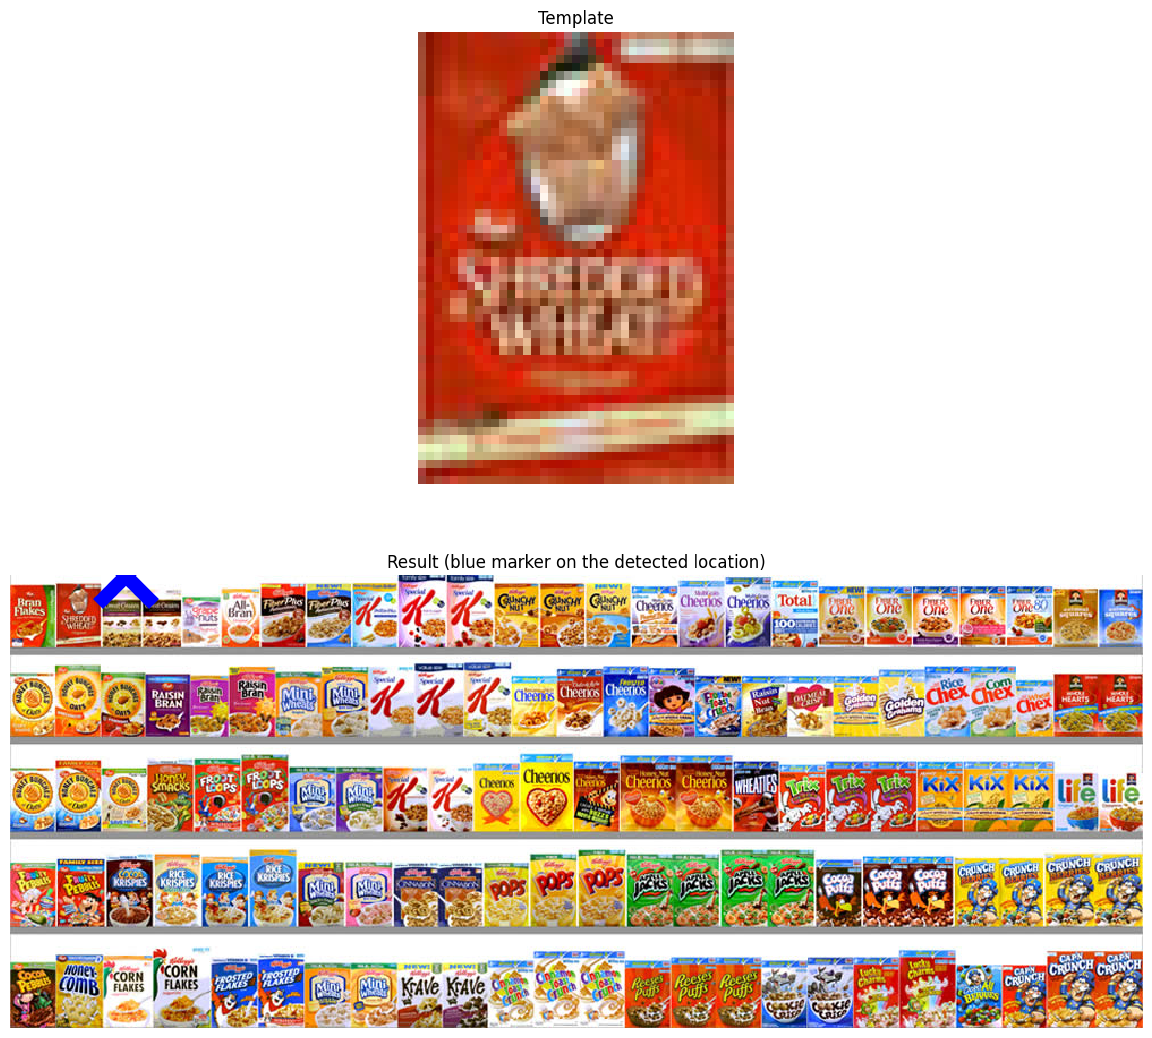

In [41]:
#from filters import zero_mean_cross_correlation

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
dsad=out.argmax()
out, image_padded = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(30, 20))

# Display product template
plt.subplot(311), plt.imshow(temp), plt.title('Template'), plt.axis('off')

# Display image
plt.subplot(312), plt.imshow(img), plt.title('Result (blue marker on the detected location)'), plt.axis('off')

# Display cross-correlation output
plt.subplot(313), plt.imshow(out), plt.title('Cross-correlation (white means more correlated)'), plt.axis('off')

# Draw marker at detcted location
plt.plot(image_padded, out, 'bx', ms=40, mew=10)

plt.show()

Кроме того, можно определить наличие продукта с соответствующим масштабированием и пороговым значением.

In [96]:
def check_product_on_shelf(shelf, product):
	out = zero_mean_cross_correlation(shelf, product)
	
	# Scale output by the size of the template
	out = out / float(product.shape[0] * product.shape[1])
	
	# Threshold output (this is arbitrary, you would need to tune the threshold for a real application)
	out = out > 0.1165
	
	if np.sum(out) > 0:
		print('The product is on the shelf')
	else:
		print('The product is not on the shelf')

In [93]:
# Load image of the shelf without the product
img2 = cv2.imread('lab2/img/shelf_soldout.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2_grey = cv2.imread('lab2/img/shelf_soldout.jpg', 0)

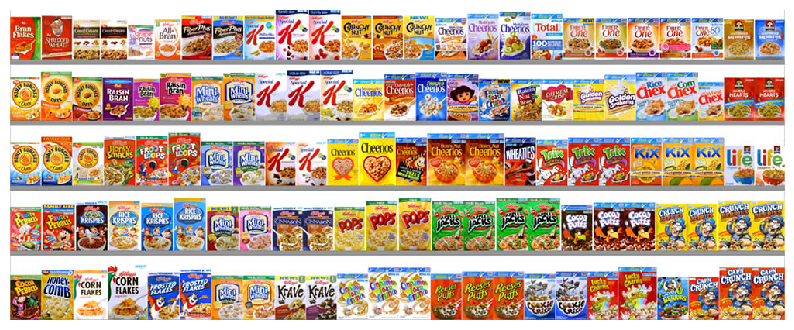

The product is on the shelf


In [94]:
plt.figure(figsize=(10, 5))
plt.imshow(img), plt.axis('off'), plt.show()
check_product_on_shelf(img_grey, temp_grey)

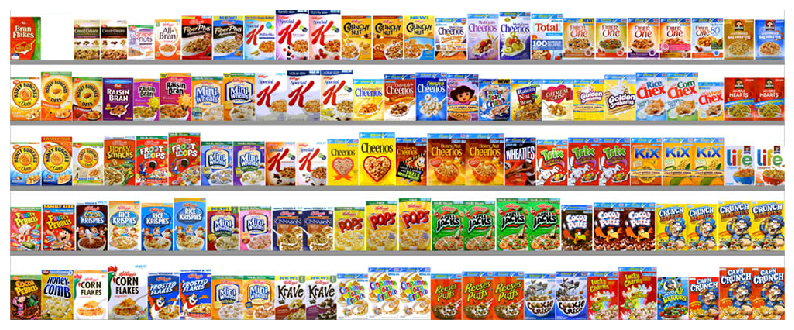

The product is on the shelf


In [95]:
plt.figure(figsize=(10, 5))
plt.imshow(img2), plt.axis('off'), plt.show()
check_product_on_shelf(img2_grey, temp_grey)

---
## Нормализованная кросс-корреляция
Однажды свет возле полки погаснет, и устройство слежения за продуктами начнет работать неисправно. `zero_mean_cross_correlation` не устойчива к изменению состояния освещения. Код, приведенный ниже, демонстрирует это.

In [102]:
def normalized_cross_correlation(f, g):
    """ Normalized cross-correlation of f and g.

    Normalize the subimage of f and the template g at each step
    before computing the weighted sum of the two.

    Hint: you should look up useful numpy functions online for calculating 
          the mean and standard deviation.

    Args:
        f: numpy array of shape (Hf, Wf).
        g: numpy array of shape (Hg, Wg).

    Returns:
        out: numpy array of shape (Hf, Wf).
    """
	
    Hi, Wi = f.shape  
    Hk, Wk = g.shape  
    pad_height = Hk // 2      
    pad_width = Wk // 2 
	
    padded_image = zero_pad(f, pad_height, pad_width)  
    out = np.zeros_like(f)
    g_zero_mean = g - np.mean(g)    
    sigma_g = np.std(g)
    for i in range(Hi):   
        for j in range(Wi):   
            image_region = padded_image[i:i + Hk, j:j + Wk]
            image_region_zero_mean = image_region - np.mean(image_region)
            sigma_f = np.std(image_region)

            if sigma_f > 0 and sigma_g > 0:
                out[i, j] = np.sum(g_zero_mean * image_region_zero_mean) / (sigma_f * sigma_g)
            else:
                out[i, j] = 0

    return out

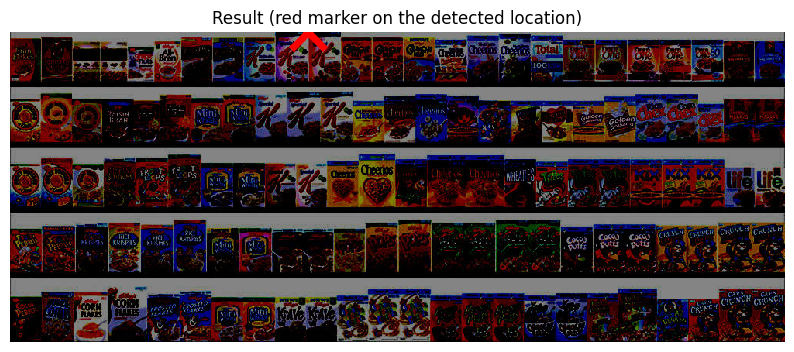

In [103]:
#from filters import normalized_cross_correlation

# Load image
img = cv2.imread('lab2/img/shelf_dark.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_grey = cv2.imread('lab2/img/shelf_dark.jpg', 0)

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
out, image_padded = np.unravel_index(out.argmax(), out.shape)

plt.figure(figsize=(10, 5))

# Display image
plt.imshow(img), plt.title('Result (red marker on the detected location)'), plt.axis('off')

# Draw marker at detcted location
plt.plot(image_padded, out, 'rx', ms=25, mew=5)
plt.show()

Решение заключается в нормализации пикселей изображения и шаблона на каждом шаге перед их сравнением. Это называется **нормализованной кросс-корреляцией**.

Математическим определением нормализованной кросс-корреляции является $f$ и шаблон $g$:
$$(f\star{g})[m,n]=\sum_{i,j} \frac{f[i,j]-\overline{f_{m,n}}}{\sigma_{f_{m,n}}} \cdot \frac{g[i-m,j-n]-\overline{g}}{\sigma_g}$$

Где:
- $f_{m,n}$ - это патч-изображение в позиции $(m,n)$
- $\overline{f_{m,n}}$ - это среднее значение изображения патча $f_{m,n}$.
- $\sigma_{f_{m,n}}$ - стандартное отклонение изображения патча $f_{m,n}$ 
- $\overline{g}$ - это среднее значение шаблона $g$.
- $\sigma_g$ - стандартное отклонение шаблона $g$.

Реализуйте функцию **`normalized_cross_correlation`** в файле **`filters.py`** и запустите код ниже.

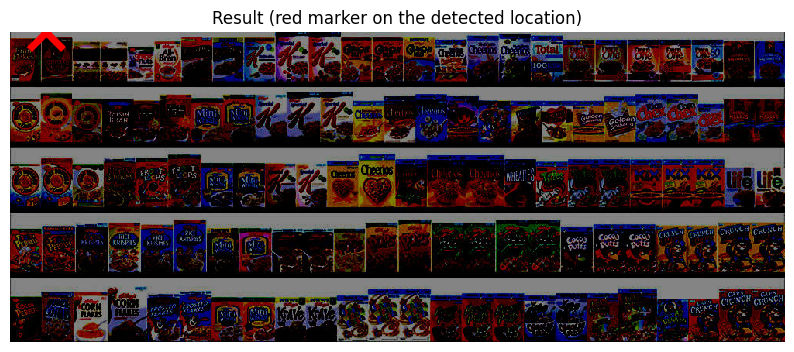

In [104]:
#from filters import normalized_cross_correlation

# Perform normalized cross-correlation between the image and the template
out = normalized_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
out, image_padded = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(10, 5))

# Display image
plt.imshow(img), plt.title('Result (red marker on the detected location)'), plt.axis('off')

# Draw marker at detcted location
plt.plot(image_padded, out, 'rx', ms=25, mew=5)
plt.show()